<a href="https://colab.research.google.com/github/annasajkh/AnimeSketch2Real/blob/main/AnimeSketch2Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run this to setup everything
#@markdown only run this once

!gdown --id 1Ej-FFKN0m1BrjzFBfVTV4bgIuzE-7ki3
!pip install rudalle==0.4.0 > /dev/null

!pip install bitsandbytes-cuda110==0.25.0 > /dev/null
!pip install timm==0.4.12 > /dev/null

import torch
import torchvision
from rudalle import get_rudalle_model, get_tokenizer, get_vae, utils, get_realesrgan
from rudalle.pipelines import generate_images, show, super_resolution
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

realesrgan = get_realesrgan("x2", device=device)
model = get_rudalle_model("Malevich", pretrained=True, fp16=True, device=device, loss_img_weight=10**3, mlp_activation="gelu")
vae = get_vae().to(device)
tokenizer = get_tokenizer()
checkpoint = torch.load("AnimeSketch2Real.pt")
model.load_state_dict(checkpoint)

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [ ]:
#@title Run this to upload an image
#@markdown you can also run this to change the image

from rudalle.image_prompts import ImagePrompts
from google.colab import files
import os
import numpy as np


uploaded = files.upload()

for fn in uploaded.keys():
  name = fn

del uploaded

Saving download 2.png to download 2.png


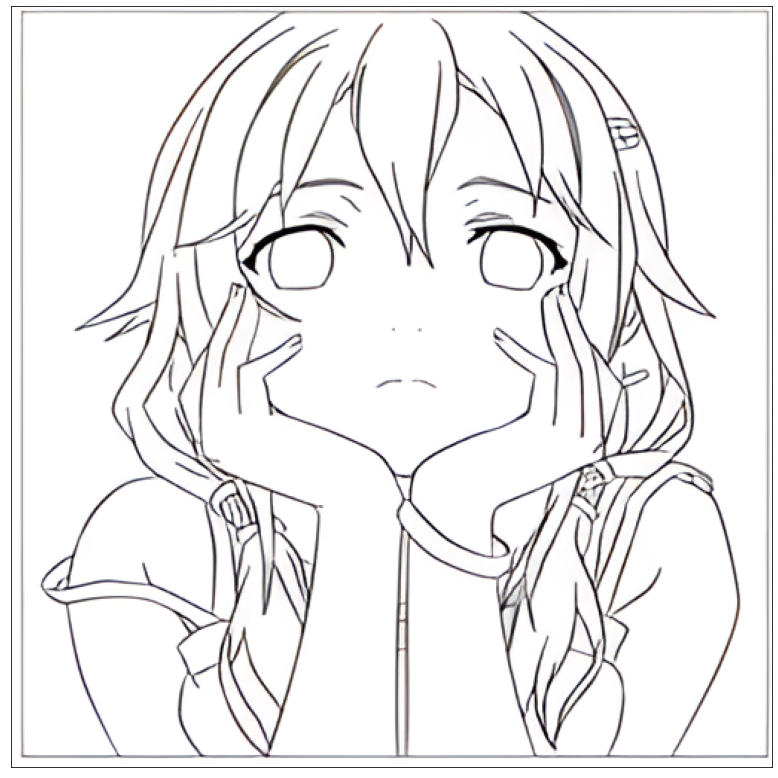

  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

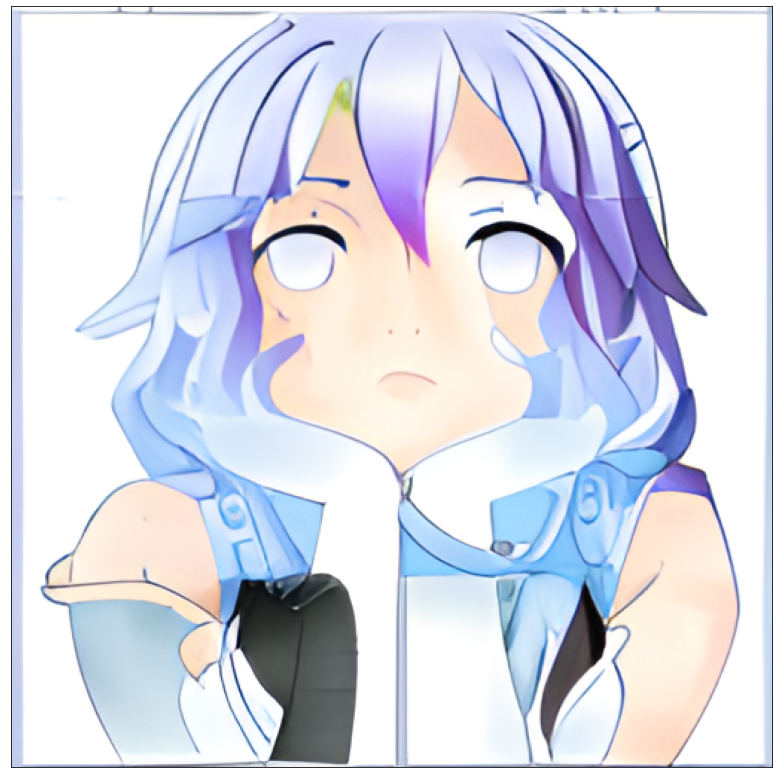

In [ ]:
#@title Run the AI
#@markdown you can run this multiple times and you will get different result

temperature = 1.0 #@param {type:"number"}
top_k =  2048#@param {type:"integer"}
top_p = 1.0 #@param {type:"number"}

image = Image.open(name).convert("RGB")
image = expand2square(image, (255, 255, 255)).resize((256, 256), Image.BICUBIC)
image1 = Image.fromarray(np.array(image)[:128, :, :])
image2 = Image.fromarray(np.array(image)[128:, :, :])
image = super_resolution([Image.fromarray(np.concatenate([image1, image2]))], realesrgan)[0].resize((256, 256), Image.BICUBIC)

show(super_resolution([PIL.Image.fromarray(np.concatenate([image1, image2]))], realesrgan), 1)

image_prompt = ImagePrompts(image1, {'up': 128, 'left': 0, 'right': 0, 'down': 0}, vae, torch.device('cuda'), crop_first=False)

pil_image = generate_images("Сверху набросок, снизу готовый вариант",
                            tokenizer,
                            model,
                            vae,
                            top_k=top_k,
                            temperature=temperature,
                            images_num=1,
                            top_p=top_p,
                            bs=8,
                            image_prompts=image_prompt, 
                            use_cache=True)[0]

image_complete = []

image_complete.append(np.array(pil_image[0])[128:, :, :][:64, :, :])

#show([Image.fromarray(np.array(pil_image[0])[128:, :, :])], 1)

image_half_colored = PIL.Image.fromarray(np.concatenate([np.array(image)[64:128+64, :, :], np.array(pil_image[0])[128:, :, :][64:128, :, :]]))

#show([image_half_colored], 1)

image_prompt = ImagePrompts(image_half_colored, {'up': 128+64, 'left': 0, 'right': 0, 'down': 0}, vae, torch.device('cuda'), crop_first=False)

pil_image = generate_images("Сверху набросок, снизу готовый вариант",
                            tokenizer,
                            model,
                            vae,
                            top_k=top_k,
                            temperature=temperature,
                            images_num=1,
                            top_p=top_p,
                            bs=8,
                            image_prompts=image_prompt, 
                            use_cache=True)[0]

#show([pil_image[0]], 1)

image_complete.append(np.array(pil_image[0])[128:, :, :])

image_half_colored = Image.fromarray(np.concatenate([np.array(image)[128:, :, :], np.array(pil_image[0])[128+64:, :, :]]))

#show([image_half_colored], 1)

image_prompt = ImagePrompts(image_half_colored, {'up': 128+64, 'left': 0, 'right': 0, 'down': 0}, vae, torch.device('cuda'), crop_first=False)

pil_image = generate_images("Сверху набросок, снизу готовый вариант",
                            tokenizer,
                            model,
                            vae,
                            top_k=top_k,
                            temperature=temperature,
                            images_num=1,
                            top_p=top_p,
                            bs=8,
                            image_prompts=image_prompt, 
                            use_cache=True)[0]

image_complete.append(np.array(pil_image[0])[128+64:, :, :])
#show([Image.fromarray(np.array(pil_image[0])[128:, :, :])], 1)

pil_image_result = np.concatenate(image_complete)

pil_image_result = (torch.tensor(pil_image_result).to(device).float() / 255)[None,:]
pil_image_result = torch.permute(pil_image_result, (0, 3, 1, 2))

pil_image_result = vae.decode(vae.get_codebook_indices(pil_image_result))

pil_image_result = torch.squeeze(pil_image_result).permute(1,2,0).detach().cpu().numpy()
pil_image_result = Image.fromarray((pil_image_result * 255).astype("uint8"))

pil_image_result = super_resolution([pil_image_result], realesrgan)


show(pil_image_result, 1)